# Access and Customize ICESat-2 Data Tutorial

#### This tutorial will walk you though how to access ICESat-2 data at the NASA National Snow and Ice Data Center Distributed Active Archive Center (NSIDC DAAC) using spatial and temporal filters, as well as how to request  customization services including subsetting and reformatting using an Application Programming Interface, or API. 

#### Here are the steps you will learn in this tutorial:
       1) Setting up NASA Earthdata Login authentication for direct data access.
       2) Obtaining data set metadata.
       3) Inputting data set search criteria using spatial and temporal filters. 
       4) Exploring different methods of specifying spatial criteria including lat/lon bounds,
       polygon coordinate pairs, and polygon input from a Shapefile or KML.  
       5) Searching for matching files and receiving information about file volume.
       6) Obtaining information about subsetting and reformatting capabilities for a specfic data set.
       7) Configuring data request by "chunking" request by file number. 
       8) Submitting a request and monitoring the status of the request.
       
#### Data Used:
* `s3://pangeo-data-upload-oregon/icesat2/pine_island_glims/glims_polygons.kml` 
* `s3://pangeo-data-upload-oregon/icesat2/data-access-subsetted-outputs/`
* `s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/`



## Import packages


In [1]:
import requests
import getpass
import socket
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import h5py
# To read KML files with geopandas, we will need to enable KML support in fiona (disabled by default)
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth

## Pull data from s3 bucket

#### We will pull the following folders from our Amazon s3 bucket:
    1) Pine Island Glacier outline
    2) Data outputs with subsetting applied
    3) Data outputs without subsetting applied

#### The Pine Island Glacier outline will be used below for filtering and subsetting the data. We are also pulling the data outputs that we will request directly from NSIDC below, so we can have a quick look at the data outside of the access request.

Steps to pull data from s3:

    1) Open terminal window in Pangeo: File -> New -> Terminal
    2) Move to the data-access notebook working directory by changing to the following directory:

`cd /home/jovyan/data-access/`
    
    3) Copy each line to your terminal and hit enter in between each line:

`aws s3 sync s3://pangeo-data-upload-oregon/icesat2/pine_island_glims/ pine_island_glims/` </br>
`aws s3 sync s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/ data-access-outputs/` </br>
`aws s3 sync s3://pangeo-data-upload-oregon/icesat2/data-access-subsetted-outputs/ data-access-subsetted-outputs/ `

#### Data Sources:
The Pine Island Glacier outline was originally downloaded from the the NSIDC [Global Land Ice Measurements from Space (GLIMS) database](http://www.glims.org/maps/glims). Direct download access: http://www.glims.org/maps/info.html?anlys_id=528486

The unsubsetted data are from the ATL06 data set (more resources below): https://doi.org/10.5067/ATLAS/ATL06.001

The subsetted data were generated using the [NASA Earth Observing System Data and Information System (EOSDIS)](https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-services) Service Interface (ESI).

## Create a token

#### We will generate a token needed in order to access data using your Earthdata Login credentials, and we will apply that token to the following queries. If you do not already have an Earthdata Login account, go to http://urs.earthdata.nasa.gov to register. Your password will be prompted for privacy.

In [2]:
# Earthdata Login credentials

# Enter your Earthdata Login user name
uid = 'amy.steiker'
# Enter your email address associated with your Earthdata Login account
email = 'amy.steiker@nsidc.org'
pswd = getpass.getpass('Earthdata Login password: ')

Earthdata Login password:  ·········


In [3]:
# Request token from Common Metadata Repository using Earthdata credentials
token_api_url = 'https://cmr.earthdata.nasa.gov/legacy-services/rest/tokens'
hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)

data = {
    'token': {
        'username': uid,
        'password': pswd,
        'client_id': 'NSIDC_client_id',
        'user_ip_address': ip
    }
}
headers={'Accept': 'application/json'}
response = requests.post(token_api_url, json=data, headers=headers)
token = json.loads(response.content)['token']['id']
print(token)

A0DD140D-5B20-3476-352D-6320196663CB


## Select a data set of interest and explore resources available through NSIDC. 

#### Let's begin discovering ICESat-2 data by first inputting the data set of interest.

#### See the [ICESat-2 Data Sets](https://nsidc.org/data/icesat-2/data-sets "ICESat-2 Data Sets") page for a list of all ICESat-2 data set titles and IDs. Below we will input data set ID ATL06, which is the ID for the "ATLAS/ICESat-2 L3A Land Ice Height" data set.

In [4]:
# Input data set ID (e.g. ATL06) of interest here, also known as "short name".

short_name = 'ATL06'

### From the ICESat-2 Data Sets page, you can find a link to each data set home page:

ATL03: https://nsidc.org/data/atl03 </br>
ATL06: https://nsidc.org/data/atl06 </br>
ATL07: https://nsidc.org/data/atl07

### From that home page, several resources are available, including an online user guide (within the User Guide tab of the landing page):

ATL03: https://nsidc.org/data/atl03?qt-data_set_tabs=3#qt-data_set_tabs </br>
ATL06: https://nsidc.org/data/atl06?qt-data_set_tabs=3#qt-data_set_tabs </br>
ATL07: https://nsidc.org/data/atl07?qt-data_set_tabs=3#qt-data_set_tabs

### As well as a data dictionary with every data set variable described in detail:

ATL03: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL03-data-dictionary-v001.pdf </br>
ATL06: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL06-data-dictionary-v001.pdf </br>
ATL07: https://nsidc.org/sites/nsidc.org/files/technical-references/ATL07-data-dictionary-v001.pdf

### A note on data access options:

We will be pursuing data discovery and access "programmatically" using Application Programming Interfaces, or APIs. 

_What is an API? API stands for Application Programming Interface. You can think of it as a middle man between an application or end-use (in this case, us) and a data provider. In this case, the data provider is both the metadata repository housing ICESat-2 data information (the [Common Metadata Repository](https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/cmr) and NSIDC). These APIs are essentially structured as a URL with a base plus individual key-value-pairs (KVPs) separated by ‘&’._

There are other discovery and access methods available from NSIDC, as you can see from the data set home pages under the 'Download Data' tab, including [OpenAltimetry](https://openaltimetry.org/) and [NASA Earthdata Search](http://search.earthdata.nasa.gov). 

## Determine the number and size of granules available within a time range and location.

#### Let's explore information about our data set. We'll start by determining the most recent version number of our data set. We will also find out how many data granules (files) exist over an area and time of interest. [The Common Metadata Repository](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html "CMR API documentation") is queried to explore this information. 

In [5]:
# Get json response from CMR collection metadata and print results. This provides high-level metadata on a data set or "collection", provide in json format.

params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)
pprint.pprint(results)

{'feed': {'entry': [{'archive_center': 'NASA NSIDC DAAC',
                     'associations': {'services': ['S1568899363-NSIDC_ECS',
                                                   'S1613689509-NSIDC_ECS',
                                                   'S1613669681-NSIDC_ECS']},
                     'boxes': ['-90 -180 90 180'],
                     'browse_flag': False,
                     'coordinate_system': 'CARTESIAN',
                     'data_center': 'NSIDC_ECS',
                     'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V001',
                     'has_formats': True,
                     'has_spatial_subsetting': True,
                     'has_temporal_subsetting': True,
                     'has_transforms': False,
                     'has_variables': True,
                     'id': 'C1511847675-NSIDC_ECS',
                     'links': [{'href': 'https://n5eil01u.ecs.nsidc.org/ATLAS/ATL06.001/',
                                'hreflang': 'en-US',
 

#### There may be cases where more than one data set version exists, which may happen when ICESat-2 data version up. Let's make sure we have the most recent version of our data set.

In [6]:
# Find all instances of 'version_id' in metadata and print most recent version number

versions = [i['version_id'] for i in results['feed']['entry']]
latest_version = max(versions)
print(latest_version)

001


#### Now that we have the most recent version of this data set, let's determine the number of granules available over our area and time of interest. According to the [CMR API documentation](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#g-temporal), our time range must be given in `yyyy-MM-ddTHH:mm:ssZ` format.

In [7]:
# Input temporal range 

# Input start date in yyyy-MM-dd format
start_date = '2019-02-22'
# Input start time in HH:mm:ss format
start_time = '00:00:00'
# Input end date in yyyy-MM-dd format
end_date = '2019-02-22'
# Input end time in HH:mm:ss format
end_time = '23:59:59'

temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
print(temporal)

2019-02-22T00:00:00Z,2019-02-22T23:59:59Z


### Area of Interest input

#### There are three different options for inputting an area of interest to be applied to our granule (file) search:
    1) Bounding Box 
    2) Polygon coordinate pairs 
    3) Spatial file input, including Esri Shapefile or KML/KMZ. 

#### For the bounding box option, enter information in the following cell. 

In [ ]:
# # Commenting for tutorial since we will be walking through option 3 (spatial file input) together
# # Bounding Box spatial parameter in 'W,S,E,N' format

# # Input bounding box
# # Input lower left longitude in decimal degrees
# LL_lon = ''
# # Input lower left latitude in decimal degrees
# LL_lat = ''
# # Input upper right longitude in decimal degrees
# UR_lon = ''
# # Input upper right latitude in decimal degrees
# UR_lat = ''

# bounding_box = LL_lon + ',' + LL_lat + ',' + UR_lon + ',' + UR_lat
# # aoi value used for subsetting logic below
# aoi = '1'
# print(bounding_box)

#### For the polygon coordinate pair option, enter the coordinate pairs. We can do this with separate x y lists that we can join and convert to the CMR parameter format.

In [ ]:
## Commenting for tutorial since we will be walking through option 3 (spatial file input) together
# # Polygon coordinate pair spatial parameter

# #create list of x (longitude) values in decimal degrees
# x = []
# #create list of y (latitude) values in decimal degrees
# y = []
# xylist = list(zip(x, y))
# # Polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon. 
# # Input polygon coordinates as comma separated values in longitude latitude order, i.e. lon1, lat1, lon2, lat2, lon3, lat3, and so on.
# polygon = ','.join(map(str, list(sum(xylist, ()))))
# print(polygon)
# # aoi value used for subsetting logic below
# aoi = '2'

#### Let's focus on the Esri Shapefile or KML/KMZ input option.

First, we'll use geopandas to read in the file.

In [8]:
# Use geopandas to read in polygon file
# Note: a shapefile could be substituted here, or geojson, or...
kml_filepath = str('/home/jovyan/data-access/pine_island_glims/glims_polygons.kml')

#Return a GeoDataFrame object
gdf = gpd.read_file(kml_filepath)

Simple visualization of the polygon:

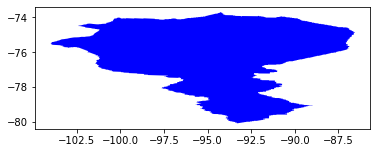

In [9]:
#render figure in notebook
%matplotlib inline

polygon_plot = gdf.plot(color='blue')

#### We need to get from the geopandas GeoDataFrame object to an input that is readable by CMR.

According to [CMR documentation](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-polygon): </br>
>Polygon points are provided in counter-clockwise order. The last point should match the first point to close the polygon. The values are listed comma separated in longitude latitude order, i.e. lon1, lat1, lon2, lat2, lon3, lat3, and so on.`


The following cell will simplify and reorder the GeoDataFrame object using the shapely package and convert the object back to a dictionary to be applied to the CMR polygon parameter.  

In [10]:
#Integer position based indexing of GeoDataFrame object to get it into a shapeply geometry object.
poly = gdf.iloc[0].geometry

#simplify polygon
poly = poly.simplify(0.05, preserve_topology=False)

# Orient counter-clockwise
poly = orient(poly, sign=1.0)

print(poly)

#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])

# aoi value used for subsetting logic below
aoi = '3'

POLYGON Z ((-86.622742 -74.908126 0, -86.561712 -74.870913 0, -86.868859 -74.73052199999999 0, -86.96290500000001 -74.60503799999999 0, -89.02594000000001 -74.316754 0, -89.630517 -74.19214700000001 0, -89.830808 -74.06591899999999 0, -90.746478 -73.95625800000001 0, -91.66821400000001 -74.023169 0, -92.049815 -73.92938700000001 0, -93.42079099999999 -73.929327 0, -93.997163 -73.882768 0, -94.27770099999999 -73.71418300000001 0, -95.133017 -73.96635499999999 0, -96.51350100000001 -74.127404 0, -99.889802 -74.085347 0, -100.114438 -74.01942200000001 0, -100.355131 -74.080906 0, -100.462734 -74.240864 0, -100.827076 -74.373988 0, -101.795349 -74.369597 0, -102.424826 -74.497263 0, -101.188725 -74.7179 0, -101.564382 -75.02970999999999 0, -103.37484 -75.273725 0, -103.914847 -75.426057 0, -104.012128 -75.5223 0, -103.029452 -75.748774 0, -102.350567 -75.749245 0, -101.837882 -75.943066 0, -101.899461 -76.01408600000001 0, -101.280944 -76.192769 0, -101.325735 -76.246168 0, -101.190803 -76

Now our coordinate pairs are ready for CMR:

In [11]:
print(polygon)

-86.622742,-74.908126,-86.561712,-74.870913,-86.868859,-74.730522,-86.962905,-74.605038,-89.02594,-74.316754,-89.630517,-74.192147,-89.830808,-74.065919,-90.746478,-73.956258,-91.668214,-74.023169,-92.049815,-73.929387,-93.420791,-73.929327,-93.997163,-73.882768,-94.277701,-73.714183,-95.133017,-73.966355,-96.513501,-74.127404,-99.889802,-74.085347,-100.114438,-74.019422,-100.355131,-74.080906,-100.462734,-74.240864,-100.827076,-74.373988,-101.795349,-74.369597,-102.424826,-74.497263,-101.188725,-74.7179,-101.564382,-75.02971,-103.37484,-75.273725,-103.914847,-75.426057,-104.012128,-75.5223,-103.029452,-75.748774,-102.350567,-75.749245,-101.837882,-75.943066,-101.899461,-76.014086,-101.280944,-76.192769,-101.325735,-76.246168,-101.190803,-76.27106,-101.250474,-76.342292,-101.175067,-76.345822,-101.402436,-76.52035,-101.326063,-76.523929,-101.449791,-76.666392,-101.310795,-76.691373,-101.357407,-76.744819,-101.217404,-76.769752,-101.295133,-76.85887,-101.058051,-76.962123,-100.447336,-7

The following cell provides an alternative option to post a file to OGR service for spatial file input conversion to CMR polygon format:

In [ ]:
# # Alternative option for spatial file input: Post file to OGR service
# # Spatial file input, including Esri Shapefile or KML/KMZ
    
# # POST shapefile or KML polygon to OGR for geojson conversion
# url = 'http://ogre.adc4gis.com/convert'
# shapefile = str(os.getcwd()) + '/pine_island_glims/glims_polygons.kml'
# files = {'upload': open(shapefile, 'rb')}
# r = requests.post(url, files=files)
# results = json.loads(r.content)
# # Results is a dictionary representing a feature collection. List coordinates from the Polygon feature:
# polygon_list = list(results['features'][0]['geometry']['coordinates'][0])     
# # Remove z value from polygon list
# for i in range(len(polygon_list)):
#     del polygon_list[i][2] 
# # Create shapely Polygon object for simplification and counter-clockwise ordering for CMR filtering
# poly = Polygon(tuple(polygon_list))

# #Same simplify and orient steps as above:
# #simplify polygon
# poly = poly.simplify(0.05, preserve_topology=False)

# # Orient counter-clockwise
# poly = orient(poly, sign=1.0)

# #Format dictionary to polygon coordinate pairs for CMR polygon filtering
# # Polygon points need to be provided in counter-clockwise order as comma separated values in longitude latitude order, i.e. lon1, lat1, lon2, lat2, lon3, lat3, and so on. 
# # The last point should match the first point to close the polygon. 
# polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])

# # aoi value used for subsetting logic below
# aoi = '3'

#### We will now populate dictionaries to be applied to our search query below based on spatial and temporal inputs. For additional search parameters, see the [The Common Metadata Repository API documentation](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html "CMR API documentation").


In [12]:
#Create CMR parameters used for granule search. Modify params depending on bounding_box or polygon input.

if aoi == '1':
# bounding box input:
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'bounding_box': bounding_box
    }
else:
    
# If polygon input (either via coordinate pairs or shapefile/KML/KMZ):
    params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }

print('CMR search parameters: ', params)

CMR search parameters:  {'short_name': 'ATL06', 'version': '001', 'temporal': '2019-02-22T00:00:00Z,2019-02-22T23:59:59Z', 'page_size': 100, 'page_num': 1, 'polygon': '-86.622742,-74.908126,-86.561712,-74.870913,-86.868859,-74.730522,-86.962905,-74.605038,-89.02594,-74.316754,-89.630517,-74.192147,-89.830808,-74.065919,-90.746478,-73.956258,-91.668214,-74.023169,-92.049815,-73.929387,-93.420791,-73.929327,-93.997163,-73.882768,-94.277701,-73.714183,-95.133017,-73.966355,-96.513501,-74.127404,-99.889802,-74.085347,-100.114438,-74.019422,-100.355131,-74.080906,-100.462734,-74.240864,-100.827076,-74.373988,-101.795349,-74.369597,-102.424826,-74.497263,-101.188725,-74.7179,-101.564382,-75.02971,-103.37484,-75.273725,-103.914847,-75.426057,-104.012128,-75.5223,-103.029452,-75.748774,-102.350567,-75.749245,-101.837882,-75.943066,-101.899461,-76.014086,-101.280944,-76.192769,-101.325735,-76.246168,-101.190803,-76.27106,-101.250474,-76.342292,-101.175067,-76.345822,-101.402436,-76.52035,-101.3

#### Input the parameter dictionary to the CMR granule search to query all files (granules) that meet the criteria based on the granule metadata. Print the number of granules returned.

In [13]:
# Query number of granules using our (paging over results)

granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
while True:
    response = requests.get(granule_search_url, params=params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    params['page_num'] += 1

    
# Get number of granules over my area and time of interest
len(granules)


4

#### We can view this in the [NASA Earthdata Search web interface](https://search.earthdata.nasa.gov/search/granules?polygon=-86.625%2C-74.900390625%2C-87.029296875%2C-74.6015625%2C-90.298828125%2C-74.021484375%2C-93.427734375%2C-73.93359375%2C-94.359375%2C-73.74023437500001%2C-96.767578125%2C-74.126953125%2C-100.107421875%2C-74.021484375%2C-100.828125%2C-74.37304687500001%2C-102.427734375%2C-74.49609375%2C-101.25%2C-74.70703125%2C-101.548828125%2C-75.02343750000001%2C-104.009765625%2C-75.515625%2C-102.357421875%2C-75.744140625%2C-101.28515625%2C-76.201171875%2C-101.197265625%2C-76.271484375%2C-101.443359375%2C-76.658203125%2C-101.03906250000001%2C-76.93945312500001%2C-96.521484375%2C-77.484375%2C-96.43359375%2C-77.677734375%2C-97.611328125%2C-78.029296875%2C-95.02734375%2C-78.591796875%2C-94.9921875%2C-78.732421875%2C-95.677734375%2C-78.99609375%2C-95.27343750000001%2C-79.119140625%2C-95.431640625%2C-79.2421875%2C-93.990234375%2C-79.611328125%2C-93.884765625%2C-79.875%2C-93.234375%2C-80.0859375%2C-91.705078125%2C-79.875%2C-91.810546875%2C-79.857421875%2C-91.494140625%2C-79.8046875%2C-91.458984375%2C-79.646484375%2C-90.43945312500001%2C-79.59375%2C-90.544921875%2C-79.55859375%2C-90.03515625%2C-79.2421875%2C-88.98046875%2C-79.083984375%2C-92.03906250000001%2C-78.416015625%2C-92.109375%2C-78.310546875%2C-90.73828125%2C-77.90625000000001%2C-92.390625%2C-77.501953125%2C-92.197265625%2C-77.37890625%2C-92.337890625%2C-77.203125%2C-91.01953125%2C-77.150390625%2C-91.880859375%2C-76.869140625%2C-87.064453125%2C-75.884765625%2C-86.87109375%2C-75.708984375%2C-87.08203125%2C-75.4453125%2C-86.607421875%2C-75.005859375%2C-86.625%2C-74.900390625&p=C1511847675-NSIDC_ECS!C1511847675-NSIDC_ECS&pg[1][v]=t&m=-74.09615279797836!-130.36684058200473!1!2!0!0%2C2&qt=2019-02-22T00%3A00%3A00.000Z%2C2019-02-22T23%3A59%3A59.000Z&q=atl06&ok=atl06&sf=5633090487), which relies on the same metadata, although their simplified polygon may differ slightly. With the same search criteria applied, we can view the same 4 granules of ATL06 over the glacier.


#### Now query the average size of those granules: 

In [14]:
granule_sizes = [float(granule['granule_size']) for granule in granules]

# Average size of granules in MB
mean(granule_sizes)

59.2271811962

#### As well as the total volume:

In [15]:
# Total volume in MB
sum(granule_sizes)

236.9087247848

#### Although subsetting, reformatting, or reprojecting can alter the size of the granules, this "native" granule size can still be used to guide us towards the best download method to pursue, which we will come back to later on in this tutorial.

## Select the subsetting and reformatting services enabled for your data set of interest.

The NSIDC DAAC supports customization services on many of our NASA Earthdata mission collections. Reformatting and subsetting are available on all Level-2 and -3 ICESat-2 data sets. Let's discover the specific service options supported for this data set and select which of these services we want to request. 

We will start by querying the service capability to gather and select customization options.

In [16]:
# Query service capability URL 

from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

print(capability_url)

https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL06.001.xml


All of NSIDC's service endpoints are behind NASA Earthdata Login. We need to create a session to store cookies and pass Earthdata Login credentials to capabilities url.

In [17]:
# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content)

From the service capability XML, we can collect lists with each service option to gather service information.

In [18]:
#collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]

# variable subsetting
variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
variables_raw = [variables[i]['value'] for i in range(len(variables))]
variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
variable_vals = [v.replace(':', '/') for v in variables_join]

# reformatting
formats = [Format.attrib for Format in root.iter('Format')]
format_vals = [formats[i]['value'] for i in range(len(formats))]
format_vals.remove('')

# reprojection only applicable on ICESat-2 L3B products, yet to be available. 

# reformatting options that support reprojection
normalproj = [Projections.attrib for Projections in root.iter('Projections')]
normalproj_vals = []
normalproj_vals.append(normalproj[0]['normalProj'])
format_proj = normalproj_vals[0].split(',')
format_proj.remove('')
format_proj.append('No reformatting')

#reprojection options
projections = [Projection.attrib for Projection in root.iter('Projection')]
proj_vals = []
for i in range(len(projections)):
    if (projections[i]['value']) != 'NO_CHANGE' :
        proj_vals.append(projections[i]['value'])
        
# reformatting options that do not support reprojection
no_proj = [i for i in format_vals if i not in format_proj]

#### Let's confirm that subset services exist for our data set by reviewing the `subagent` list. If the list contains service information, we know that services are available. If not, we need to set the `agent` API parameter to `NO` to indicate that our request will bypass the subsetter. This will quickly send back the data "natively" without any customization applied.

In [19]:
print(subagent)
if len(subagent) < 1 :
    agent = 'NO'

[{'id': 'ICESAT2', 'spatialSubsetting': 'true', 'spatialSubsettingShapefile': 'true', 'temporalSubsetting': 'true', 'type': 'both', 'maxGransSyncRequest': '100', 'maxGransAsyncRequest': '2000'}]


More information is contained in the subagent list, including the maximum number of granules that we can request per order depending on our configuration. We'll come back to these options below.

### We'll begin populating the subsetting and reformatting parameters used for our NSIDC API request. In addition to the CMR information we queried above, the NSIDC API accepts Key-Value-Pairs (KVPs) for subsetting and reformatting services.

#### Let's start with spatial subsetting. Recall that there are three options to *filter* our search results by spatial constraint: 

1) Bounding Box: Corresponding to the CMR `bounding_box` KVP

2) Polygon coordinate pairs: Corresponding to the CMR `polygon` KVP

3) Spatial file input, including Esri Shapefile or KML/KMZ: We simplified the file input to also be read by the CMR `polygon` KVP 
    
#### We see above that `spatialSubsetting` is `true` and `spatialSubsettingShapefile` is `true`. Therefore the same *filtering* options can be applied to our *subset* constraint, with unique KVPs for the subsetting service:

1) Bounding Box: `bbox` subset KVP

2) Polygon coordinate pairs: `bounding_shape` subset KVP in [GeoJSON](https://geojson.org/) format. 

3) Spatial file input: The file can be read directly by the subsetter without simplification. This file will be posted to the API endpoint, so we don't need to specify an additional subset KVP here. 

#### Because we're pursuing option 3), we don't need to provide an additional subset parameter. Below is commented code for bounding box inputs.

In [ ]:
# # Bounding box subsetting (bbox) in same format as bounding_box

# bbox = bounding_box

# # Polygon coordinate pair subsetting in GeoJSON format. Or for simplicity, get polygon bounds to be used as bounding box input

# # Create shapely Polygon object from x y list
# p = Polygon(tuple(xylist))
# # Extract the point values that define the perimeter of the polygon
# bounds = p.bounds
# bbox = ','.join(map(str, list(bounds)))

#### Temporal subsetting is next, since we saw above that `temporalSubsetting` is `true`. We filtered data over 22 Feb 2019 and we can also subset the data to those dates if desired. 

The `time` KVP is used to subset temporally. This can be entered in the following formats:

`time=yyyy-mm-dd,yyyy-mm-dd`

`time=yyy-mm-ddThh:MM:ss,yyy-mm-ddThh:MM:ss` 

In [20]:
# Temporal subsetting KVP

timevar = start_date + 'T' + start_time + ',' + end_date + 'T' + end_time

#### Next, let's explore the reformatting options available.


In [21]:
print(format_vals)

['TABULAR_ASCII', 'NetCDF4-CF', 'Shapefile', 'NetCDF-3']


These options can be inputted into the API request exactly as printed in the list, with quotes removed, using the `format=` Key-Value-Pair. For example:

`format=NetCDF4-CF`

We will be exploring the data in its native HDF5 format so we won't pursue this option in this tutorial. The reformatting cell is commented below. 

#### Reprojection options will be available on the gridded ICESat-2 L3B data sets. Let's confirm that no reprojection options exist:

In [22]:
print(proj_vals)

[]


#### Finally, let's determine if variable subsetting is available by finding the length of the `variable_vals` list we gathered from the capabilities URL. 

In [23]:
len(variable_vals)

627

We can view the entire list of variables if desired:

In [ ]:
# pprint.pprint(variable_vals)

And we can enter a list of variables to subset separated by comma using the `coverage` key. All forward slashes need to be included to indicate HDF group hierarchy.

In [24]:
coverage = '/ancillary_data/atlas_sdp_gps_epoch,\
/gt1l/land_ice_segments/atl06_quality_summary,\
/gt1l/land_ice_segments/delta_time,\
/gt1l/land_ice_segments/h_li,\
/gt1l/land_ice_segments/h_li_sigma,\
/gt1l/land_ice_segments/latitude,\
/gt1l/land_ice_segments/longitude,\
/gt1l/land_ice_segments/segment_id,\
/gt1l/land_ice_segments/sigma_geo_h,\
/gt1r/land_ice_segments/atl06_quality_summary,\
/gt1r/land_ice_segments/delta_time,\
/gt1r/land_ice_segments/h_li,\
/gt1r/land_ice_segments/h_li_sigma,\
/gt1r/land_ice_segments/latitude,\
/gt1r/land_ice_segments/longitude,\
/gt1r/land_ice_segments/segment_id,\
/gt1r/land_ice_segments/sigma_geo_h,\
/gt2l/land_ice_segments/atl06_quality_summary,\
/gt2l/land_ice_segments/delta_time,\
/gt2l/land_ice_segments/h_li,\
/gt2l/land_ice_segments/h_li_sigma,\
/gt2l/land_ice_segments/latitude,\
/gt2l/land_ice_segments/longitude,\
/gt2l/land_ice_segments/segment_id,\
/gt2l/land_ice_segments/sigma_geo_h,\
/gt2r/land_ice_segments/atl06_quality_summary,\
/gt2r/land_ice_segments/delta_time,\
/gt2r/land_ice_segments/h_li,\
/gt2r/land_ice_segments/h_li_sigma,\
/gt2r/land_ice_segments/latitude,\
/gt2r/land_ice_segments/longitude,\
/gt2r/land_ice_segments/segment_id,\
/gt2r/land_ice_segments/sigma_geo_h,\
/gt3l/land_ice_segments/atl06_quality_summary,\
/gt3l/land_ice_segments/delta_time,\
/gt3l/land_ice_segments/h_li,\
/gt3l/land_ice_segments/h_li_sigma,\
/gt3l/land_ice_segments/latitude,\
/gt3l/land_ice_segments/longitude,\
/gt3l/land_ice_segments/segment_id,\
/gt3l/land_ice_segments/sigma_geo_h,\
/gt3r/land_ice_segments/atl06_quality_summary,\
/gt3r/land_ice_segments/delta_time,\
/gt3r/land_ice_segments/h_li,\
/gt3r/land_ice_segments/h_li_sigma,\
/gt3r/land_ice_segments/latitude,\
/gt3r/land_ice_segments/longitude,\
/gt3r/land_ice_segments/segment_id,\
/gt3r/land_ice_segments/sigma_geo_h,\
/orbit_info/cycle_number,\
/orbit_info/rgt,\
/orbit_info/orbit_number' 

## Request data from the NSIDC data access API.

#### We will now set up our data download request. The data access and service API (labeled EGI below) incorporates the CMR parameters that we explored above, plus customization service parameters as well as a few configuration parameters.

![Data Access Service API diagram](https://gsfc-ngap-developer.s3.amazonaws.com/be03ae4ddbe19c8ea7734df6941385b8baba4741f6c7ec62fd4230eccdc31fc0)

#### As described above, the API is structured as a URL with a base plus individual key-value-pairs (KVPs) separated by ‘&’. The base URL of the NSIDC API is: </br>
`https://n5eil02u.ecs.nsidc.org/egi/request`


In [25]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

#### Let's go over the configuration parameters:

* `request_mode`
* `page_size`
* `page_num`

`request_mode` is "synchronous" by default, meaning that the request relies on a direct, continous connection between you and the API endpoint. Outputs are directly downloaded, or "streamed" to your working directory. For this tutorial, we will set the request mode to asynchronous, which will allow concurrent requests to be queued and processed without the need for a continuous connection.

Recall that we queried the total number and volume of granules prior to applying customization services. `page_size` and `page_num` can be used to adjust the number of granules per request up to a limit of 2000 granules for asynchronous, and 100 granules for synchronous. For now, let's select 10 granules to be processed in each zipped request. For ATL06, the granule size can exceed 100 MB so we want to choose a granule count that provides us with a reasonable zipped download size. 

In [26]:
# Set number of granules requested per order, which we will initially set to 10.
page_size = 10

#Determine number of pages basd on page_size and total granules. Loop requests by this value
page_num = math.ceil(len(granules)/page_size)

#Set request mode. 
request_mode = 'async'

# Determine how many individual orders we will request based on the number of granules requested

print(page_num)

1


#### After all of these KVP inputs, what does our request look like? Here's a summary of all possible KVPs that we explored, both for CMR searching and for the subsetter:

#### CMR search keys:
* `short_name=`
* `version=`
* `temporal=`
* `bounding_box=`
* `polygon=`

#### Customization keys:
* `agent=`    *(Only used if *no* customization is requested)
* `time=`
* `bbox=`
* `bounding_shape=` 
* `format=`
* `projection=`
* `projection_parameters=`
* `Coverage=`

#### Request configuration keys:
* `request_mode=` 
* `page_size=`
* `page_num=`
* `token=`
* `email=`

#### If we were to create an API request based on our request parameters and submit into a web browser for example, here's what we end up with:

In [27]:
#Print API base URL + request parameters
API_request = base_url + '?' + 'short_name=' + short_name + '&' + 'version=' + latest_version + '&' + 'temporal=' + temporal + '&' + 'time=' + timevar + '&' + 'polygon=' + polygon + '&' + 'Coverage=' + coverage + '&' + 'request_mode=' + request_mode + '&' + 'page_size=' + str(page_size) + '&' + 'page_num=' + str(page_num) + '&' + 'token=' + token + '&' + 'email=' + email
print(API_request)


https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=001&temporal=2019-02-22T00:00:00Z,2019-02-22T23:59:59Z&time=2019-02-22T00:00:00,2019-02-22T23:59:59&polygon=-86.622742,-74.908126,-86.561712,-74.870913,-86.868859,-74.730522,-86.962905,-74.605038,-89.02594,-74.316754,-89.630517,-74.192147,-89.830808,-74.065919,-90.746478,-73.956258,-91.668214,-74.023169,-92.049815,-73.929387,-93.420791,-73.929327,-93.997163,-73.882768,-94.277701,-73.714183,-95.133017,-73.966355,-96.513501,-74.127404,-99.889802,-74.085347,-100.114438,-74.019422,-100.355131,-74.080906,-100.462734,-74.240864,-100.827076,-74.373988,-101.795349,-74.369597,-102.424826,-74.497263,-101.188725,-74.7179,-101.564382,-75.02971,-103.37484,-75.273725,-103.914847,-75.426057,-104.012128,-75.5223,-103.029452,-75.748774,-102.350567,-75.749245,-101.837882,-75.943066,-101.899461,-76.014086,-101.280944,-76.192769,-101.325735,-76.246168,-101.190803,-76.27106,-101.250474,-76.342292,-101.175067,-76.345822,-101.402436,-76.5203

#### We'll also create a new dictionary of NSIDC API KVPs to be used in our request. Because we are looping through each page of requests, we'll add the `page_num` KVP to our dictionary within the loop below.

In [28]:
request_params = {
    'short_name': short_name, 
    'version': latest_version, 
    'temporal': temporal, 
    'time': timevar, 
    'polygon': polygon, 
    'Coverage': coverage, 
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email, 
    }


### Before we request the data and download the outputs, let's explore some simple comparisons of the data from s3 that we've already requested.

In [31]:
# Define paths for output folders

opath = '/home/jovyan/data-access/data-access-outputs'
sopath = '/home/jovyan/data-access/data-access-subsetted-outputs'

# Choose the same native/subsetted file to compare

native_file = opath + '/ATL06_20190222031203_08500210_001_01.h5'
processed_file = sopath + '/processed_ATL06_20190222031203_08500210_001_01.h5'

Compare file sizes:

In [32]:
os.path.getsize(native_file)

21367456

In [33]:
os.path.getsize(processed_file)

1242530

Read the files using h5py and compare the HDF5 groups and datasets:

In [34]:
# Read files using h5py package

native = h5py.File(native_file, 'r')
processed = h5py.File(processed_file, 'r')


Native file groups:

In [35]:
printGroups = True
groups = list(native.keys())
for g in groups:
    group = native[g]
    if printGroups:
        print('---')
        print('Group: {}'.format(g))
        print('---')
        for d in group.keys():
            print(group[d])

---
Group: METADATA
---
<HDF5 group "/METADATA/AcquisitionInformation" (4 members)>
<HDF5 group "/METADATA/DataQuality" (2 members)>
<HDF5 group "/METADATA/DatasetIdentification" (0 members)>
<HDF5 group "/METADATA/Extent" (0 members)>
<HDF5 group "/METADATA/Lineage" (13 members)>
<HDF5 group "/METADATA/ProcessStep" (4 members)>
<HDF5 group "/METADATA/ProductSpecificationDocument" (0 members)>
<HDF5 group "/METADATA/QADatasetIdentification" (0 members)>
<HDF5 group "/METADATA/SeriesIdentification" (0 members)>
---
Group: ancillary_data
---
<HDF5 dataset "atlas_sdp_gps_epoch": shape (1,), type "<f8">
<HDF5 dataset "control": shape (1,), type "|S100000">
<HDF5 dataset "data_end_utc": shape (1,), type "|S27">
<HDF5 dataset "data_start_utc": shape (1,), type "|S27">
<HDF5 dataset "end_cycle": shape (1,), type "<i4">
<HDF5 dataset "end_delta_time": shape (1,), type "<f8">
<HDF5 dataset "end_geoseg": shape (1,), type "<i4">
<HDF5 dataset "end_gpssow": shape (1,), type "<f8">
<HDF5 dataset "e

Subsetted file groups:

In [36]:
printGroups = True
groups = list(processed.keys())
for g in groups:
    group = processed[g]
    if printGroups:
        print('---')
        print('Group: {}'.format(g))
        print('---')
        for d in group.keys():
            print(group[d])


---
Group: METADATA
---
<HDF5 group "/METADATA/AcquisitionInformation" (4 members)>
<HDF5 group "/METADATA/DataQuality" (2 members)>
<HDF5 group "/METADATA/DatasetIdentification" (0 members)>
<HDF5 group "/METADATA/Extent" (0 members)>
<HDF5 group "/METADATA/Lineage" (13 members)>
<HDF5 group "/METADATA/ProcessStep" (4 members)>
<HDF5 group "/METADATA/ProductSpecificationDocument" (0 members)>
<HDF5 group "/METADATA/QADatasetIdentification" (0 members)>
<HDF5 group "/METADATA/SeriesIdentification" (0 members)>
---
Group: ancillary_data
---
<HDF5 dataset "atlas_sdp_gps_epoch": shape (1,), type "<f8">
---
Group: gt1l
---
<HDF5 group "/gt1l/land_ice_segments" (8 members)>
---
Group: gt1r
---
<HDF5 group "/gt1r/land_ice_segments" (8 members)>
---
Group: gt2l
---
<HDF5 group "/gt2l/land_ice_segments" (8 members)>
---
Group: gt2r
---
<HDF5 group "/gt2r/land_ice_segments" (8 members)>
---
Group: gt3l
---
<HDF5 group "/gt3l/land_ice_segments" (8 members)>
---
Group: gt3r
---
<HDF5 group "/gt3r

Compare geolocation range from the /gt1l/land_ice_segments group:

In [37]:
with h5py.File(native_file,'r') as native:
    native_groups = list(native.keys())
    n_hvar = native['/gt1l/land_ice_segments/h_li']
    n_h = n_hvar[:]
    n_latvar = native['/gt1l/land_ice_segments/latitude']
    n_latitude = n_latvar[:]
    n_lonvar = native['/gt1l/land_ice_segments/longitude']
    n_longitude = n_lonvar[:]

with h5py.File(processed_file,'r') as processed:
    processed_groups = list(processed.keys())
    p_hvar = processed['/gt1l/land_ice_segments/h_li']
    p_h = p_hvar[:]
    p_latvar = processed['/gt1l/land_ice_segments/latitude']
    p_latitude = p_latvar[:]
    p_lonvar = processed['/gt1l/land_ice_segments/longitude']
    p_longitude = p_lonvar[:]
    
print('array size of native file height variable:')
print(len(n_h))
print('array size of subsetted height variable:')
print(len(p_h))

print('native file latitude range:')
print(min(n_latitude), max(n_latitude))
print('native file longitude range:')
print(min(n_longitude), max(n_longitude))

print('subsetted file latitude range:')
print(min(p_latitude), max(p_latitude))
print('subsetted file longitude range:')
print(min(p_longitude), max(p_longitude))

array size of native file height variable:
17965
array size of subsetted height variable:
6890
native file latitude range:
-79.0073823818177 -71.42557447321147
native file longitude range:
-100.00773826372749 -95.21117551470294
subsetted file latitude range:
-77.30068865327192 -74.20384025265416
subsetted file longitude range:
-98.48516801258202 -96.4963418258078


## Request Data

#### Finally, we'll download the data directly to this notebook directory in a new Outputs folder. The progress of each order will be reported.

We'll start by creating an output folder if the folder does not already exist.

In [38]:
path = str(os.getcwd() + '/Outputs')
if not os.path.exists(path):
    os.mkdir(path)

In [39]:
# Request data service for each page number, and unzip outputs

for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    request_params.update( {'page_num': page_val} )
    
# Post polygon to API endpoint for polygon subsetting to subset based on original, non-simplified KML file

    shape_post = {'shapefile': open(kml_filepath, 'rb')}
    request = session.post(base_url, params=request_params, files=shape_post) 
    
# FOR ALL OTHER REQUESTS THAT DO NOT UTILIZED AN UPLOADED POLYGON FILE, USE A GET REQUEST INSTEAD OF POST:
#     request = session.get(base_url, params=request_params)
    
    print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
    request.raise_for_status()
    print('Order request URL: ', request.url)
    esir_root = ET.fromstring(request.content)
    print('Order request response XML content: ', request.content)

# Look up order ID
    orderlist = []   
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID: ', orderID)

# Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ', statusURL)

# Find order status
    request_response = session.get(statusURL)    
    print('HTTP response from order response URL: ', request_response.status_code)
    
# Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request ', page_val, ' is submitting...')
    print('Initial request status is ', status)

# Continue to loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        time.sleep(10)
        loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
        loop_response.raise_for_status()
        loop_root = ET.fromstring(loop_response.content)

# Find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is: ', status)
        if status == 'pending' or status == 'processing':
            continue

# Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
    if status == 'complete_with_errors' or status == 'failed':
        messagelist = []
        for message in loop_root.findall("./processInfo/"):
            messagelist.append(message.text)
        print('error messages:')
        pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
    if status == 'complete' or status == 'complete_with_errors':
        downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
        print('Zip download URL: ', downloadURL)
        print('Beginning download of zipped output...')
        zip_response = session.get(downloadURL)
        # Raise bad request: Loop will stop for bad response code.
        zip_response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')
    else: print('Request failed.')


Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=001&temporal=2019-02-22T00%3A00%3A00Z%2C2019-02-22T23%3A59%3A59Z&time=2019-02-22T00%3A00%3A00%2C2019-02-22T23%3A59%3A59&polygon=-86.622742%2C-74.908126%2C-86.561712%2C-74.870913%2C-86.868859%2C-74.730522%2C-86.962905%2C-74.605038%2C-89.02594%2C-74.316754%2C-89.630517%2C-74.192147%2C-89.830808%2C-74.065919%2C-90.746478%2C-73.956258%2C-91.668214%2C-74.023169%2C-92.049815%2C-73.929387%2C-93.420791%2C-73.929327%2C-93.997163%2C-73.882768%2C-94.277701%2C-73.714183%2C-95.133017%2C-73.966355%2C-96.513501%2C-74.127404%2C-99.889802%2C-74.085347%2C-100.114438%2C-74.019422%2C-100.355131%2C-74.080906%2C-100.462734%2C-74.240864%2C-100.827076%2C-74.373988%2C-101.795349%2C-74.369597%2C-102.424826%2C-74.497263%2C-101.188725%2C-74.7179%2C-101.564382%2C-75.02971%2C-103.37484%2C-75.273725%2C-103.914847%2C-75.426057%2C-104.012128%2C-75.5223%2C-103.029452%2C-75.748774%2C-102.350567%2

#### Why did we get an error? 

Errors can occur when our search filter overestimates the extent of the data contained within the granule. CMR uses orbit metadata to determine the extent of the file, but it does not inspect the values themselves. This can be a relatively common error for ICESat-2 search and access because of the limitations of the metadata, but it only means that more data were returned in the search results as a "false positive" than what the subsetter found when cropping the data values. 

#### Now we'll try the same request but without any subsetting services applied (instead we want the data "as-is" using the `agent=NO` KVP. We'll remove the `time` and `coverage` service keys, and we'll add `agent=NO`.

In [40]:
request_params = {
    'short_name': short_name, 
    'version': latest_version, 
    'temporal': temporal, 
    'polygon': polygon, 
    'agent' : 'NO',
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email, 
    }

Let's run our request loop again:

In [41]:

# Request data service for each page number, and unzip outputs

for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    request_params.update( {'page_num': page_val} )
    
# For all requests other than spatial file upload, use get function
    request = session.get(base_url, params=request_params)
    
    print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
    request.raise_for_status()
    print('Order request URL: ', request.url)
    esir_root = ET.fromstring(request.content)
    print('Order request response XML content: ', request.content)

#Look up order ID
    orderlist = []   
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID: ', orderID)

#Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ', statusURL)

#Find order status
    request_response = session.get(statusURL)    
    print('HTTP response from order response URL: ', request_response.status_code)
    
# Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request ', page_val, ' is submitting...')
    print('Initial request status is ', status)

#Continue loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        time.sleep(10)
        loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
        loop_response.raise_for_status()
        loop_root = ET.fromstring(loop_response.content)

#find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is: ', status)
        if status == 'pending' or status == 'processing':
            continue

#Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
    if status == 'complete_with_errors' or status == 'failed':
        messagelist = []
        for message in loop_root.findall("./processInfo/"):
            messagelist.append(message.text)
        print('error messages:')
        pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
    if status == 'complete' or status == 'complete_with_errors':
        downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
        print('Zip download URL: ', downloadURL)
        print('Beginning download of zipped output...')
        zip_response = session.get(downloadURL)
        # Raise bad request: Loop will stop for bad response code.
        zip_response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')
    else: print('Request failed.')


Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=001&temporal=2019-02-22T00%3A00%3A00Z%2C2019-02-22T23%3A59%3A59Z&polygon=-86.622742%2C-74.908126%2C-86.561712%2C-74.870913%2C-86.868859%2C-74.730522%2C-86.962905%2C-74.605038%2C-89.02594%2C-74.316754%2C-89.630517%2C-74.192147%2C-89.830808%2C-74.065919%2C-90.746478%2C-73.956258%2C-91.668214%2C-74.023169%2C-92.049815%2C-73.929387%2C-93.420791%2C-73.929327%2C-93.997163%2C-73.882768%2C-94.277701%2C-73.714183%2C-95.133017%2C-73.966355%2C-96.513501%2C-74.127404%2C-99.889802%2C-74.085347%2C-100.114438%2C-74.019422%2C-100.355131%2C-74.080906%2C-100.462734%2C-74.240864%2C-100.827076%2C-74.373988%2C-101.795349%2C-74.369597%2C-102.424826%2C-74.497263%2C-101.188725%2C-74.7179%2C-101.564382%2C-75.02971%2C-103.37484%2C-75.273725%2C-103.914847%2C-75.426057%2C-104.012128%2C-75.5223%2C-103.029452%2C-75.748774%2C-102.350567%2C-75.749245%2C-101.837882%2C-75.943066%2C-101.899461%2C

#### Clean up the Output folder by removing individual order folders:

In [42]:
#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))

OSError: [Errno 39] Directory not empty: '/home/jovyan/data-access/notebooks/Outputs/161340094'

In [45]:
#List files
sorted(os.listdir(path))

['ATL06_20190222031203_08500210_001_01.h5',
 'ATL06_20190222031203_08500210_001_01.iso.xml',
 'ATL06_20190222031944_08500211_001_01.h5',
 'ATL06_20190222031944_08500211_001_01.iso.xml',
 'ATL06_20190222155404_08580211_001_01.h5',
 'ATL06_20190222155404_08580211_001_01.iso.xml',
 'ATL06_20190222155947_08580212_001_01.h5',
 'ATL06_20190222155947_08580212_001_01.iso.xml',
 'processed_ATL06_20190222031203_08500210_001_01.h5',
 'processed_ATL06_20190222155404_08580211_001_01.h5',
 'processed_ATL06_20190222155947_08580212_001_01.h5']

### To review, we have explored data availability and volume over a region and time of interest, discovered and selected data customization options, and downloaded data directly to our Pangeo environment. You are welcome to modify the search and service parameters to submit more requests to NSIDC.

In [ ]:
#move outputs to s3
#os.rename('Outputs', 'data-access-subsetted-outputs')

# aws s3 sync data-access-outputs/ s3://pangeo-data-upload-oregon/icesat2/data-access-outputs/
# aws s3 sync data-access-subsetted-outputs/ s3://pangeo-data-upload-oregon/icesat2/data-access-subsetted-outputs/

#shutil.rmtree('/home/jovyan/data-access/notebooks/data-access-outputs')
#shutil.rmtree('/home/jovyan/data-access/notebooks/data-access-subsetted-outputs')

In [ ]:
# #remove Outputs folder for testing
# outputpath = '/home/jovyan/data-access/notebooks/Outputs'
# shutil.rmtree(outputpath)

# glacier_path = '/home/jovyan/data-access/pine_island_glims'
# shutil.rmtree(glacier_path)

# aopath = '/home/jovyan/data-access/data-access-outputs'
# shutil.rmtree(aopath)
# sopath = '/home/jovyan/data-access/data-access-subsetted-outputs'
# shutil.rmtree(sopath)